In [1]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from pandas import DataFrame
import pandas as pd
from sklearn.metrics import mean_absolute_error

# split a univariate dataset into train/test sets
def split_dataset(data,n):
	# split into standard weeks
	train, test = data[0:-n], data[-n:]    
	#restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	train = array(split(train, len(train)/4))
	test = array(split(test, len(test)/4))    
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	mae_scores = list()      
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		mae = mean_absolute_error(actual[:, i], predicted[:, i])            
		# store
		scores.append(rmse)
		mae_scores.append(mae)        
	# calculate overall RMSE
	s = 0
	rmse_=DataFrame(scores)           
	mae_=DataFrame(mae_scores)    
	sonuc=pd.concat([rmse_, mae_], axis=1, ignore_index=True)        
	export_sonuc= sonuc.to_excel (r'C:\Users\sezgi.sener\Desktop\New folder\deep_learning_time_series_forecasting\code\MULTIVARIATE\multivariate_encoder_decoder_lstm_sonuc.xlsx', index = None, header=True)        
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=4):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, test,n_input):
	# prepare data
	train_x, train_y = to_supervised(train,n_input)
	test_x, test_y = to_supervised(test, n_input)    
	#print(train_x)   
	# define parameters
	verbose, epochs, batch_size = 0, 50, 50
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))    
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(150, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	plot_model(model, show_shapes=True, to_file='mult_encoder_decoder_lstm.png')       
	# fit network
	repeats=1
	for i in range(repeats):
		#model.set_weights(initial_weights)      
		model.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy','mape'])          
		aa=model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,validation_data=(test_x, test_y), verbose=verbose) 
		pyplot.plot(aa.history['loss'],  color='blue')
		pyplot.plot(aa.history['val_loss'], color='orange')
		#print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, xx.history['loss'].iloc[-1], xx.history['val_loss'].iloc[-1]))
		model.reset_states() 
		#reset_weights(model)         
	pyplot.savefig('epochs_diagnostic_encoder_lstm.png')   
	pyplot.legend()
	pyplot.show()         
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, test,n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)  
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
# load the new file
from sklearn import preprocessing
dataset = read_csv('simithaftalik_2.csv', sep=',', header=0, index_col=0, 
         encoding='latin-1') 
#print(dataset)
#dataset=dataset[['SalesCount','Price','temp','Max_temp','Min_temp','snow','precip','gunes','Ramazan','IsNationalHoliday','Month','MonthDT','Year']]
dataset=dataset[['SalesCount','Price','temp','Max_temp','Min_temp','snow','precip','gunes','Ramazan','IsNationalHoliday','Year']]
dataset["Ramazan"] = dataset["Ramazan"].astype('float')
dataset["IsNationalHoliday"] = dataset["IsNationalHoliday"].astype('float')
dataset["Year"] = dataset["Year"].astype('category')
#dataset["Month"] = dataset["Month"].astype('category')
#dataset["MonthDT"] = dataset["MonthDT"].astype('category')
print(dataset.dtypes)
le = preprocessing.LabelEncoder()
le.fit(dataset['Year'])
dataset['Year']=le.transform(dataset['Year'])

#le.fit(dataset['Month'])
#dataset['Month']=le.transform(dataset['Month'])

#le.fit(dataset['MonthDT'])
#dataset['MonthDT']=le.transform(dataset['MonthDT'])

son = list()
for n in [8,9,10,11,12,13]:
	#print(n)    
	train, test = split_dataset(dataset.values,n*4)
	# define the names and functions for the models we wish to evaluate
	n_input =4
	score, scores = evaluate_model(train, test, n_input)
	# summarize scores
	summarize_scores('cnn', score, scores)
	# evaluate each model
	print(score,scores)
	son.append(scores)
weeks = ['1', '2', '3', '4']
a=0
for i in [8,9,10,11,12,13]:
	pyplot.plot(weeks, DataFrame(son).T[a], marker='o', label=i*4)   
	a=a+1   
pyplot.title('Haftalik Satislar Çok Değişkenli LSTM')
pyplot.xlabel('HAFTA')
pyplot.ylabel('RMSE HATA')    
pyplot.savefig('multivariate_lstm_haftalik.png',show_shapes=True, show_layer_names=True) 
pyplot.legend()
pyplot.show()
print(DataFrame(son))
pyplot.boxplot(DataFrame(son).T)
pyplot.title('Haftalik Satislar Çok Değişkenli LSTM BOX PLOT')
pyplot.xlabel('HAFTA')
pyplot.ylabel('RMSE HATA')
pyplot.savefig('multivariate_lstm_haftalik_boxplot.png',show_shapes=True, show_layer_names=True) 
pyplot.show()

Using TensorFlow backend.


SalesCount            float64
Price                 float64
temp                  float64
Max_temp              float64
Min_temp              float64
snow                  float64
precip                float64
gunes                 float64
Ramazan               float64
IsNationalHoliday     float64
Year                 category
dtype: object
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

cnn: [39.052] 19.0, 47.9, 45.8, 36.6
39.0519438861763 [18.97526205102419, 47.949359291578425, 45.82745839807912, 36.61775789616447]


No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

cnn: [33.918] 13.3, 42.5, 39.5, 32.5
33.91784435980012 [13.329241665679893, 42.54728266214313, 39.458071854540144, 32.50847429170592]


No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

cnn: [36.697] 14.8, 47.0, 42.0, 34.6
36.69660069992434 [14.83732525149796, 46.98914558688412, 41.95479531746094, 34.61548215558769]


No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

cnn: [43.203] 15.0, 48.9, 49.4, 49.1
43.203113698009375 [15.028515699471235, 48.86552632646519, 49.414728077450754, 49.0970924583406]


No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

cnn: [37.765] 21.6, 47.6, 41.9, 35.0
37.76546823250458 [21.59714256515515, 47.58613528597124, 41.85338828283246, 34.96197003190945]


No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

cnn: [47.030] 23.6, 53.7, 55.3, 48.6
47.030377898891054 [23.636614828572746, 53.65070848101733, 55.25552719116704, 48.55063400441706]


<Figure size 640x480 with 1 Axes>

           0          1          2          3
0  18.975262  47.949359  45.827458  36.617758
1  13.329242  42.547283  39.458072  32.508474
2  14.837325  46.989146  41.954795  34.615482
3  15.028516  48.865526  49.414728  49.097092
4  21.597143  47.586135  41.853388  34.961970
5  23.636615  53.650708  55.255527  48.550634


<Figure size 640x480 with 1 Axes>

SalesCount            float64
Price                 float64
temp                  float64
Max_temp              float64
Min_temp              float64
snow                  float64
precip                float64
gunes                 float64
Ramazan               float64
IsNationalHoliday     float64
Year                 category
dtype: object


No handles with labels found to put in legend.


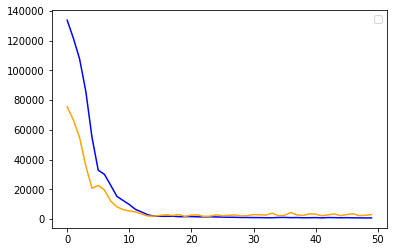

cnn: [46.811] 12.3, 36.2, 38.8, 39.9
46.81137348444286 [12.3202168600898, 36.18270730491828, 38.847899398720855, 39.921739522898946]


No handles with labels found to put in legend.


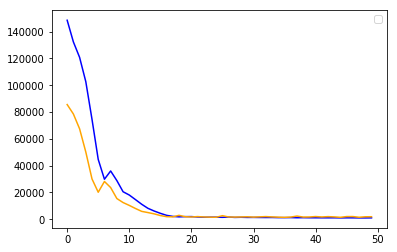

cnn: [36.992] 10.9, 31.3, 30.1, 25.3
36.99214707627147 [10.863193235535517, 31.3118888464764, 30.149056047217137, 25.27953948161691]


No handles with labels found to put in legend.


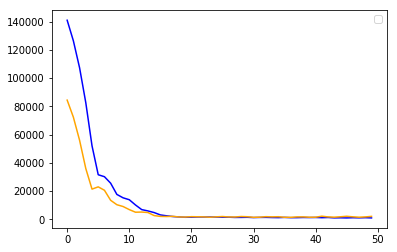

cnn: [34.285] 14.1, 27.8, 32.1, 26.0
34.28483558618701 [14.057557915160208, 27.8090001725327, 32.14254933491583, 26.030050548558545]


No handles with labels found to put in legend.


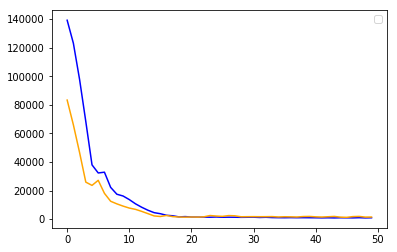

cnn: [51.988] 19.7, 43.5, 47.4, 45.8
51.98803573299341 [19.74018081605453, 43.45483407053424, 47.381832057985065, 45.84397737122418]


No handles with labels found to put in legend.


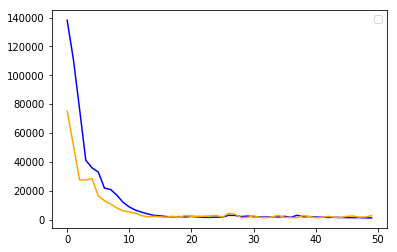

cnn: [38.275] 14.8, 31.7, 29.4, 26.1
38.27516692739971 [14.838998834862428, 31.677637787866527, 29.41636265917712, 26.119218275489374]


No handles with labels found to put in legend.


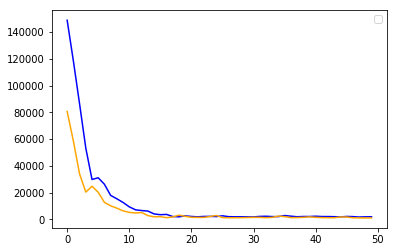

cnn: [48.122] 37.1, 44.9, 46.4, 45.9
48.121966219310906 [37.07672642247631, 44.91442893549774, 46.40183786568405, 45.931221578611606]


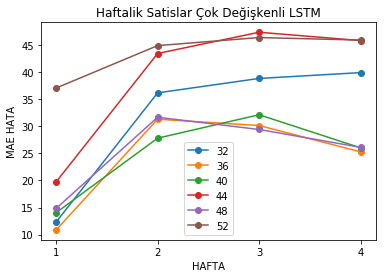

           0          1          2          3
0  12.320217  36.182707  38.847899  39.921740
1  10.863193  31.311889  30.149056  25.279539
2  14.057558  27.809000  32.142549  26.030051
3  19.740181  43.454834  47.381832  45.843977
4  14.838999  31.677638  29.416363  26.119218
5  37.076726  44.914429  46.401838  45.931222


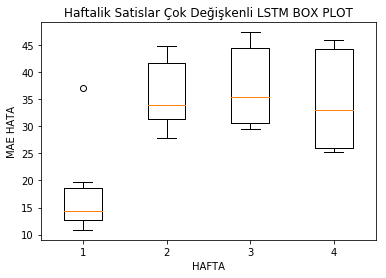

In [2]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from pandas import DataFrame
import pandas as pd
from sklearn.metrics import mean_absolute_error

# split a univariate dataset into train/test sets
def split_dataset(data,n):
	# split into standard weeks
	train, test = data[0:-n], data[-n:]    
	#restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	train = array(split(train, len(train)/4))
	test = array(split(test, len(test)/4))    
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	mae_scores = list()      
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		mae = mean_absolute_error(actual[:, i], predicted[:, i])            
		# store
		scores.append(mae)
		mae_scores.append(rmse)        
	# calculate overall RMSE
	s = 0
	rmse_=DataFrame(scores)           
	mae_=DataFrame(mae_scores)    
	sonuc=pd.concat([rmse_, mae_], axis=1, ignore_index=True)        
	export_sonuc= sonuc.to_excel (r'C:\Users\sezgi.sener\Desktop\New folder\deep_learning_time_series_forecasting\code\MULTIVARIATE\multivariate_encoder_decoder_lstm_sonuc.xlsx', index = None, header=True)        
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=4):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, test,n_input):
	# prepare data
	train_x, train_y = to_supervised(train,n_input)
	test_x, test_y = to_supervised(test, n_input)    
	#print(train_x)   
	# define parameters
	verbose, epochs, batch_size = 0, 50, 50
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))    
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(150, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	plot_model(model, show_shapes=True, to_file='mult_encoder_decoder_lstm.png')       
	# fit network
	repeats=1
	for i in range(repeats):
		#model.set_weights(initial_weights)      
		model.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy','mape'])          
		aa=model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,validation_data=(test_x, test_y), verbose=verbose) 
		pyplot.plot(aa.history['loss'],  color='blue')
		pyplot.plot(aa.history['val_loss'], color='orange')
		#print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, xx.history['loss'].iloc[-1], xx.history['val_loss'].iloc[-1]))
		model.reset_states() 
		#reset_weights(model)         
	pyplot.savefig('epochs_diagnostic_encoder_lstm.png')   
	pyplot.legend()
	pyplot.show()         
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, test,n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)  
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
# load the new file
from sklearn import preprocessing
dataset = read_csv('simithaftalik_2.csv', sep=',', header=0, index_col=0, 
         encoding='latin-1') 
#print(dataset)
#dataset=dataset[['SalesCount','Price','temp','Max_temp','Min_temp','snow','precip','gunes','Ramazan','IsNationalHoliday','Month','MonthDT','Year']]
dataset=dataset[['SalesCount','Price','temp','Max_temp','Min_temp','snow','precip','gunes','Ramazan','IsNationalHoliday','Year']]
dataset["Ramazan"] = dataset["Ramazan"].astype('float')
dataset["IsNationalHoliday"] = dataset["IsNationalHoliday"].astype('float')
dataset["Year"] = dataset["Year"].astype('category')
#dataset["Month"] = dataset["Month"].astype('category')
#dataset["MonthDT"] = dataset["MonthDT"].astype('category')
print(dataset.dtypes)
le = preprocessing.LabelEncoder()
le.fit(dataset['Year'])
dataset['Year']=le.transform(dataset['Year'])

#le.fit(dataset['Month'])
#dataset['Month']=le.transform(dataset['Month'])

#le.fit(dataset['MonthDT'])
#dataset['MonthDT']=le.transform(dataset['MonthDT'])

son = list()
for n in [8,9,10,11,12,13]:
	#print(n)    
	train, test = split_dataset(dataset.values,n*4)
	# define the names and functions for the models we wish to evaluate
	n_input =4
	score, scores = evaluate_model(train, test, n_input)
	# summarize scores
	summarize_scores('cnn', score, scores)
	# evaluate each model
	print(score,scores)
	son.append(scores)
weeks = ['1', '2', '3', '4']
a=0
for i in [8,9,10,11,12,13]:
	pyplot.plot(weeks, DataFrame(son).T[a], marker='o', label=i*4)   
	a=a+1   
pyplot.title('Haftalik Satislar Çok Değişkenli LSTM')
pyplot.xlabel('HAFTA')
pyplot.ylabel('MAE HATA')    
pyplot.savefig('multivariate_lstm_haftalik.png',show_shapes=True, show_layer_names=True) 
pyplot.legend()
pyplot.show()
print(DataFrame(son))
pyplot.boxplot(DataFrame(son).T)
pyplot.title('Haftalik Satislar Çok Değişkenli LSTM BOX PLOT')
pyplot.xlabel('HAFTA')
pyplot.ylabel('MAE HATA')
pyplot.savefig('multivariate_lstm_haftalik_boxplot.png',show_shapes=True, show_layer_names=True) 
pyplot.show()